# 🗣️ Day 12 – Sentiment Analysis on Tweets (LSTM + GloVe)

 📌 In this project, we aim to:
 - Clean and preprocess real tweets (remove mentions, hashtags, URLs).
 - Use Tokenizer + padded sequences for model input.
 - Load pretrained word embeddings (GloVe).
 - Build an LSTM model for sequence classification.
 - Evaluate the model using accuracy and confusion matrix.

In [1]:
# ✅ Step 1: Import Libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Load Dataset
url = 'https://raw.githubusercontent.com/dD2405/Twitter_Sentiment_Analysis/master/train.csv'
df = pd.read_csv(url)
df = df[['tweet', 'label']]
df.columns = ['text', 'label']
df.dropna(inplace=True)
df['label'].value_counts()


label
0    29720
1     2242
Name: count, dtype: int64

In [3]:
print(df.head())

                                                text  label
0   @user when a father is dysfunctional and is s...      0
1  @user @user thanks for #lyft credit i can't us...      0
2                                bihday your majesty      0
3  #model   i love u take with u all the time in ...      0
4             factsguide: society now    #motivation      0


In [4]:
# Text Cleaning Function 
def clean_text(text):
    text = re.sub('@[A-Za-z0-9_]+', '', text)  # Remove mentions
    text = re.sub('#', '', text)               # Remove hashtags symbol (#)
    text = re.sub('RT[\s]+', '', text)         # Remove retweet tag (RT)
    text = re.sub('https?:\/\/\S+', '', text)  # Remove URLs
    text = re.sub('\W', ' ', text)             # Remove non-word characters (punctuation etc.)
    text = text.lower()                        # Convert text to lowercase
    return text

df['text'] = df['text'].apply(clean_text)


In [5]:
print(df.head())

                                                text  label
0    when a father is dysfunctional and is so sel...      0
1    thanks for lyft credit i can t use cause the...      0
2                                bihday your majesty      0
3  model   i love u take with u all the time in u...      0
4              factsguide  society now    motivation      0


In [6]:
# Create a tokenizer to convert words to numbers
# Only keep the top 10,000 most frequent words
# Words not in this list will be replaced with <OOV> (Out Of Vocabulary)
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')

# Build the word index (vocabulary) from the cleaned tweet text
tokenizer.fit_on_texts(df['text'])

# Convert each tweet into a sequence of integers
# Example: "i love this" → [2, 45, 18]
sequences = tokenizer.texts_to_sequences(df['text'])

# Pad all sequences to have the same length (150 tokens)
# If a tweet is shorter than 150 → add 0s at the end
# If a tweet is longer than 150 → cut off the extra words at the end
padded = pad_sequences(sequences, maxlen=150, padding='post', truncating='post')


In [7]:
# Preparing data for training
X = padded
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
import os
import zipfile
import requests

# Download GloVe embeddings if not already present
glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"
glove_zip = "glove.6B.zip"
glove_file = "glove.6B.100d.txt"

# Check if the file is already available
if not os.path.exists(glove_file):
    print("Downloading GloVe embeddings...")
    r = requests.get(glove_url)
    with open(glove_zip, "wb") as f:
        f.write(r.content)
    
    print("Extracting glove.6B.100d.txt...")
    with zipfile.ZipFile(glove_zip, "r") as zip_ref:
        zip_ref.extract(glove_file)
    
    print("Done!")
else:
    print("GloVe file already exists.")


GloVe file already exists.


In [9]:
# Load GloVe Embeddings
embedding_index = {}
with open("glove.6B.100d.txt", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coeffs


In [10]:
# Creating the Embedding Matrix
embedding_dim = 100
word_index = tokenizer.word_index
embedding_matrix = np.zeros((10000, embedding_dim))

for word, i in word_index.items():
    if i < 10000:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


In [11]:
# Building LSTM Model 
model = Sequential([
    Embedding(input_dim=10000, output_dim=100, weights=[embedding_matrix], trainable=False),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,000 (3.81 MB)

In [12]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2
)


Epoch 1/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 60s 182ms/step - accuracy: 0.9324 - loss: 0.3238 - val_accuracy: 0.9284 - val_loss: 0.2621
Epoch 2/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 58s 180ms/step - accuracy: 0.9293 - loss: 0.2658 - val_accuracy: 0.9284 - val_loss: 0.2580
Epoch 3/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 53s 166ms/step - accuracy: 0.9294 - loss: 0.2630 - val_accuracy: 0.9284 - val_loss: 0.2577
Epoch 4/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - accuracy: 0.9288 - loss: 0.2661 - val_accuracy: 0.9284 - val_loss: 0.2597
Epoch 5/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 60s 187ms/step - accuracy: 0.9296 - loss: 0.2614 - val_accuracy: 0.9284 - val_loss: 0.2577
Epoch 6/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 59s 186ms/step - accuracy: 0.9305 - loss: 0.2575 - val_accuracy: 0.9284 - val_loss: 0.2594
Epoch 7/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 57s 179ms/step - accuracy: 0.9298 - loss: 0.2600 - val_accuracy: 0.9284 - val_loss: 0.2577
Epoch 8/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 59s 186ms/step - accuracy: 0.9333 - loss: 0

In [13]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9342 - loss: 0.2427
Test Accuracy: 0.9287


In [14]:
# Classification Report and Prediction
y_pred = (model.predict(X_test) > 0.5).astype('int32')
print(classification_report(y_test, y_pred))


200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      5937
           1       0.00      0.00      0.00       456

    accuracy                           0.93      6393
   macro avg       0.46      0.50      0.48      6393
weighted avg       0.86      0.93      0.89      6393



d:\Programming\Machine-Learning\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Programming\Machine-Learning\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Programming\Machine-Learning\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


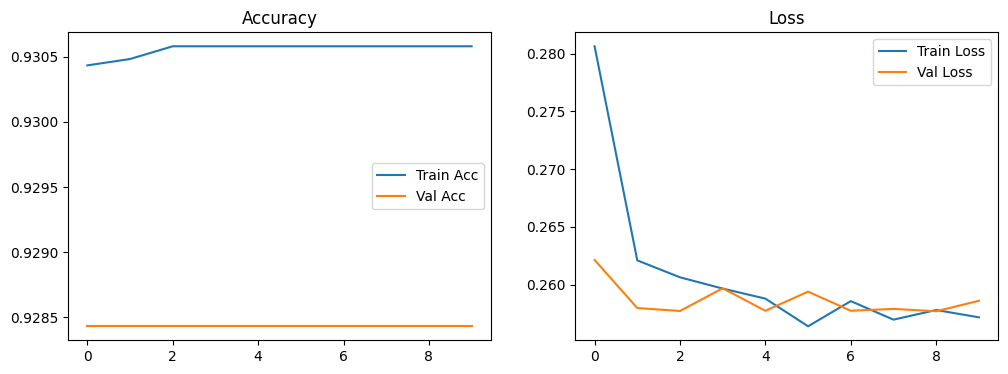

In [15]:
# Plot Accuracy and Plot curves
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")

plt.show()